In [45]:
from BenchmarkProblems.ToyAmalgam import ToyAmalgam
from BenchmarkProblems.OneMax import OneMax
import itertools

from BenchmarkProblems.RoyalRoad import RoyalRoad
from Core.get_pRef import get_pRef_from_metaheuristic

problem = RoyalRoad(5)

pRef = get_pRef_from_metaheuristic(problem=problem,
                                   sample_size=10000,
                                   which_algorithm="GA",
                                   unique=True)
print(pRef)

PRef with 1027 samples, mean = 8.03


In [5]:
from matplotlib import pyplot as plt
from typing import Optional
import seaborn as sns

import numpy as np


def show_matrix_with_colours(table: np.ndarray,
                             name: str = "",
                             row_labels=None,
                             col_labels=None,
                             save_to: Optional[str] = None,
                             fig_size: Optional[tuple[float]] = (10, 10)):
    if row_labels is None:
        row_labels = [str(i) for i in range(table.shape[0])]
    if col_labels is None:
        col_labels = [str(j) for j in range(table.shape[1])]

    fig, ax = plt.subplots(figsize=fig_size)
    sns.heatmap(
        table,
        cmap="viridis",
        center=0,
        linewidths=0.5,
        xticklabels=col_labels,
        yticklabels=row_labels,
        cbar=True
    )
    ax.set_title(name)
    plt.xticks(rotation=90, fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()

    if save_to:
        plt.savefig(save_to)
    else:
        plt.show()

In [46]:
from Core.FullSolution import FullSolution
from collections import defaultdict
import itertools
solutions_as_list = list(pRef.get_evaluated_FSs())
solutions_dict = {sol: sol.fitness for sol in solutions_as_list}
rectangles = defaultdict(list)  # (int, int)  -> (sol, sol, sol, sol)

univariate_changes = defaultdict(list)
bivariate_changes = defaultdict(list)

for sol_a, sol_b in itertools.combinations(solutions_as_list, r=2):
    diff = sol_a.values != sol_b.values
    if sum(diff) > 2:
        continue
    
    if sum(diff) == 2:
        # register bivariate
        i, j = [index for index, is_diff in enumerate(diff) if is_diff]
        a_i, a_j, b_i, b_j = (sol_a.values[i], sol_a.values[j], sol_b.values[i], sol_b.values[j])
        bivariate_changes[(i, j, a_i, a_j, b_i, b_j)].append((sol_a, sol_b))
    else:
        # register univariate
        i = [index for index, is_diff in enumerate(diff) if is_diff][0]
        a_i, b_i = (sol_a.values[i], sol_b.values[i])
        univariate_changes[(i, a_i, b_i)].append((sol_a, sol_b))

for sol_a, sol_b in itertools.combinations(solutions_as_list, r=2):
    diff = sol_a.values != sol_b.values
    if sum(diff) != 2:
        continue
    
    i, j = [index for index, is_diff in enumerate(diff) if is_diff]
    
    sol_a_i_values = sol_a.values.copy()
    sol_a_i_values[i] = sol_b.values[i]
    
    sol_a_i = FullSolution(sol_a_i_values)
    if not sol_a_i in solutions_dict:
        continue
    
    sol_a_j_values = sol_a.values.copy()
    sol_a_j_values[j] = sol_b.values[j]
    
    sol_a_j = FullSolution(sol_a_j_values)
    if not sol_a_j in solutions_dict:
        continue
        
    rectangles[(i, j)].append([sol_a, sol_b, sol_a_i, sol_a_j])


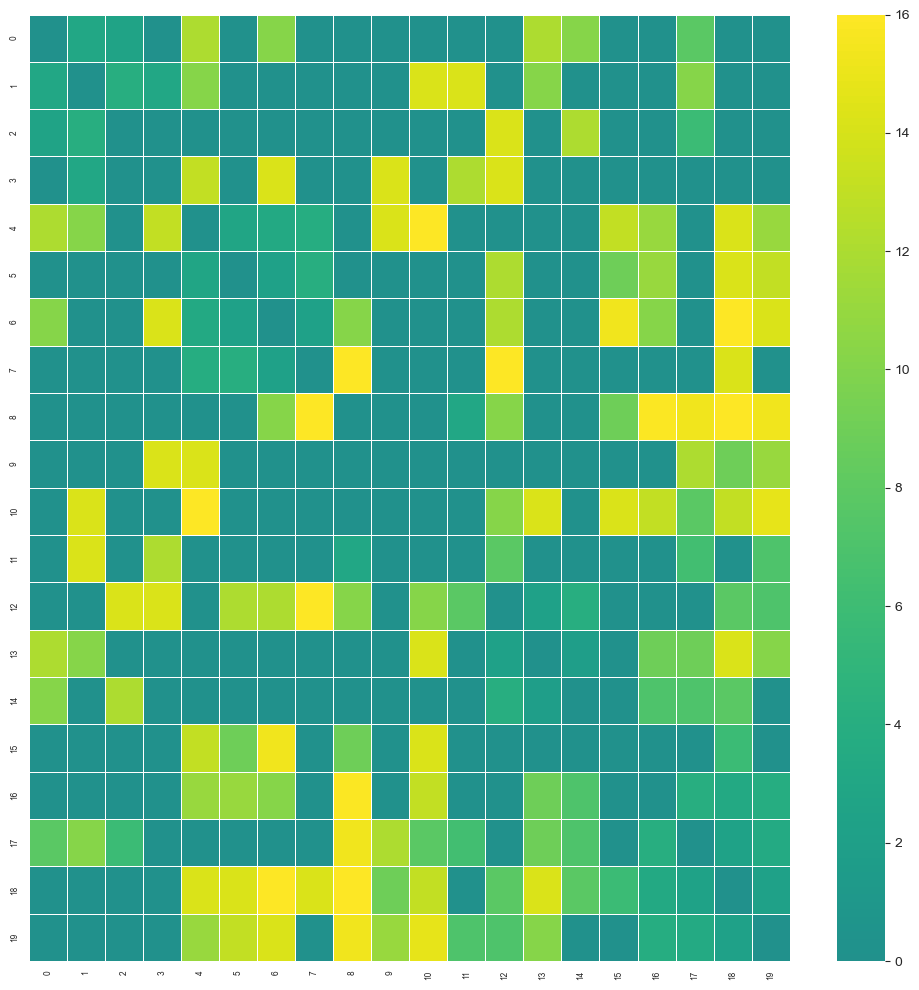

In [55]:
n = problem.search_space.amount_of_parameters
linkage_table = np.zeros(shape = (n, n), dtype=float)

for i, j in rectangles:
    surprises = []
    for (o, a, b, ab) in rectangles[(i, j)]:
         f_o, f_a, f_b, f_ab = [solutions_dict[sol] for sol in (o, a, b, ab)]
         surprise = abs(f_ab - f_a - f_b + f_o)
         surprises.append(surprise)
    linkage_table[i, j] = np.var(surprises)
    
linkage_table += linkage_table.T

show_matrix_with_colours(linkage_table)

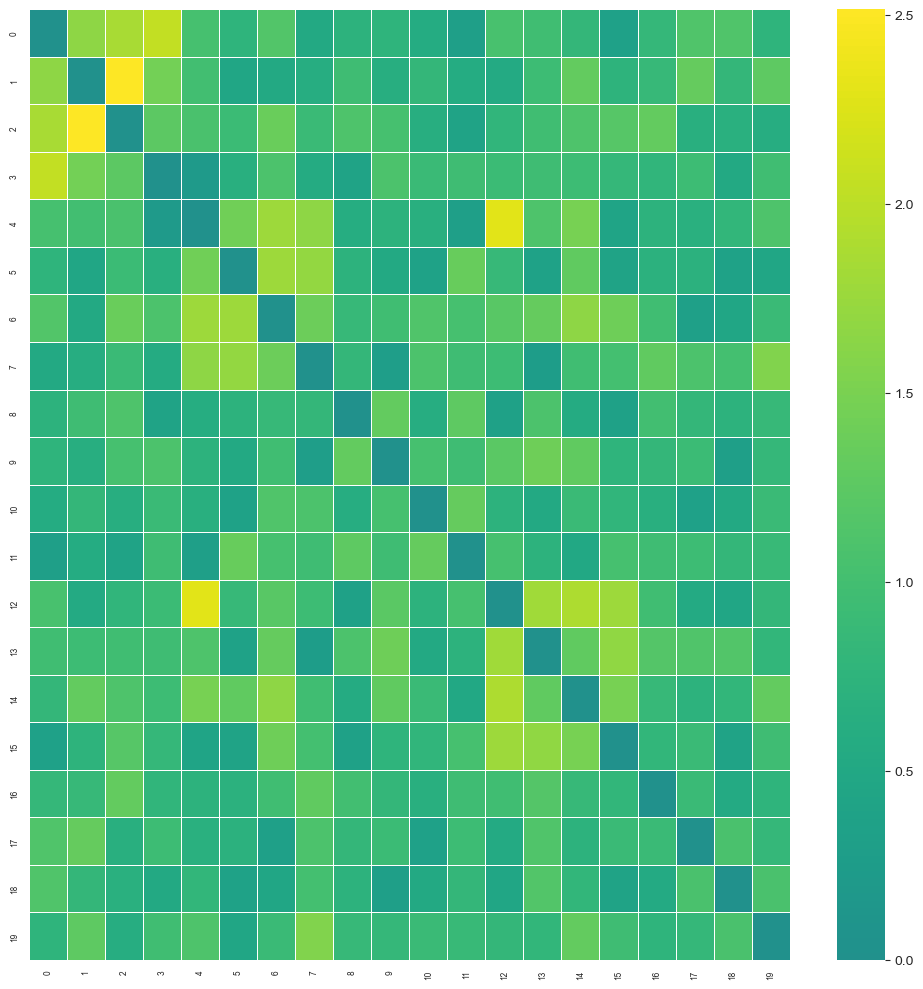

In [48]:
def average_effect(diff_pairs):
    if len(diff_pairs) == 0:
        return 0
    diffs = [s.fitness - t.fitness for s, t in diff_pairs]
    return np.average(diffs)

univariate_changes_f = {key: average_effect(value) for key, value in univariate_changes.items()}

bivariate_changes_f = {key: average_effect(value) for key, value in bivariate_changes.items()}


def get_surprise(bivariate_key):
    i, j, a_i, a_j, b_i, b_j = bivariate_key
    bivariate_effect = bivariate_changes_f[bivariate_key]
    univariate_i = univariate_changes_f[(i, a_i, b_i)]
    univariate_j = univariate_changes_f[(j, a_j, b_j)]
    return abs(bivariate_effect - univariate_i - univariate_j)

surprise_dict = defaultdict(list)
for bivariate_key in bivariate_changes_f:
    i, j, _, _, _, _ = bivariate_key
    surprise = get_surprise(bivariate_key)
    surprise_dict[(i, j)].append(surprise)


surprise_dict

lt = np.zeros((n, n))
for (i, j) in surprise_dict:
    lt[i, j] = np.average(surprise_dict[(i, j)])
    
lt += lt.T
    
show_matrix_with_colours(lt)